In [283]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools


from statsmodels.tsa.stattools import grangercausalitytests, coint
from statsmodels.tsa.vector_ar.vecm import coint_johansen

# estacionarieidad
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR

# test durbin watson
from statsmodels.stats.stattools import durbin_watson

In [2]:
df = pd.read_excel("../Datos/Acciones.xlsx",sheet_name=0)

In [327]:
class Portafolio:

    INDICES = ["76_CHL_IGPA_INDICE","77_COL_COLCAP_INDICE","78_MEX_IPC_INDICE","79_PER_LIMA GENER_INDICE"]
    PERIODO = ["PERIODO"]

    def __init__(self,df):
        self.df = df
        self.tickers_info_full = self.df.columns.to_list()
        self.tickers_info_full.remove("PERIODO")
        [self.tickers_info_full.remove(indice) for indice in Portafolio.INDICES]
        self.df_final = self.df[self.tickers_info_full]
    
    def create_df_tickers(self,list_tickers):
        tickers_info_df = pd.DataFrame(list_tickers, columns = ["column_id"])
        tickers_info_df["pais"] = tickers_info_df["column_id"].apply(lambda x: x.split("_")[1])
        self.tickers_info_df = tickers_info_df

    def permutations_tickers(self, *args, **kwargs):
        s = list(itertools.permutations(*args, **kwargs))
        ids = dict()
        for id in s:
            value_1 = id[0].split("_")[1]
            value_2 = id[1].split("_")[1]
            if value_1==value_2:
                ids[id] = 1
            else:
                ids[id] = 0

        ids_filters = [id for id in ids if ids[id] == 0]
        self.ids_filters = ids_filters
        
    def analysis_df(self,par_var):
        lista = Portafolio.PERIODO.copy()
        lista.extend(par_var)
        new_df = self.df.copy()
        new_df = new_df[lista]
        new_df = new_df.set_index("PERIODO")
        return new_df
        
    def transform_df(self,df,type_transform=None,remove_na=None):
        
        df_edit = df.copy()
        new_columns_org = df_edit.columns.tolist()

        if type_transform=="returns":            
            new_columns = ["returns_"+column for column in new_columns_org]

            for column in new_columns:
                df_edit[column] = np.log(df_edit[column.replace("returns_","")]).diff()
        
        elif type_transform=="diff":
            new_columns = ["diff_"+column for column in new_columns_org]

            for column in new_columns:
                df_edit[column] = df_edit[column.replace("diff_","")].diff()

        if type_transform:
            df_edit.drop(new_columns_org,axis=1,inplace=True)
        
        # calidad de la salida
        print("Nas:",df_edit.isna().sum())

        if remove_na:
            df_edit.dropna(inplace=True,axis=0)
            print("Correccion")
            print("Nas:",df_edit.isna().sum())

        self.apply_all(inside=True,df=df_edit.columns.tolist())
        
        return df_edit
        
    def apply_test(self,type,*args,**kwargs):

        if type=="granger-causality":

            results = grangercausalitytests(*args,**kwargs)

        elif type=="granger-cointegration":
            
            results = coint(*args,**kwargs)

        elif type=="johansen-cointegration":
            
            results = coint_johansen(*args,**kwargs)

        elif type=="response":
            pass

        return results       

    def apply_all(self,inside=False,df=None):

        if inside:
            self.create_df_tickers(list_tickers=df)
            self.permutations_tickers(iterable=self.tickers_info_df["column_id"],r=2)
        
        else:
            self.create_df_tickers(list_tickers=self.tickers_info_full)
            self.permutations_tickers(iterable=self.tickers_info_df["column_id"],r=2)

In [328]:
Portafolio = Portafolio(df)
Portafolio.apply_all()

# Diferencias vs Rendimientos

In [367]:
# vars = list(Portafolio.ids_filters[0])
# a = Portafolio.analysis_df(par_var = vars)
b = Portafolio.transform_df(df=Portafolio.df_final, type_transform="returns",remove_na=True)

Nas: returns_1_CHL_AGUAS_SERV. P              1
returns_2_CHL_ANDINA_CONS. BAS           1
returns_3_CHL_ANTAR_ENER                 1
returns_4_CHL_BANCO CREDITO_FINAN        1
returns_5_CHL_BANCO STDER_FINAN          1
                                        ..
returns_71_PER_FERREYROS_INDUST          1
returns_72_PER_ACEROS AREQUIPA_MATER     1
returns_73_PER_EMP. SIDERURGICA_MATER    1
returns_74_PER_CASA GRANDE_CONS. BAS     1
returns_75_PER_TREVALI MINING_MATER      1
Length: 75, dtype: int64
Correccion
Nas: returns_1_CHL_AGUAS_SERV. P              0
returns_2_CHL_ANDINA_CONS. BAS           0
returns_3_CHL_ANTAR_ENER                 0
returns_4_CHL_BANCO CREDITO_FINAN        0
returns_5_CHL_BANCO STDER_FINAN          0
                                        ..
returns_71_PER_FERREYROS_INDUST          0
returns_72_PER_ACEROS AREQUIPA_MATER     0
returns_73_PER_EMP. SIDERURGICA_MATER    0
returns_74_PER_CASA GRANDE_CONS. BAS     0
returns_75_PER_TREVALI MINING_MATER      0
Length: 

In [368]:
# pruebas de estacionarieidad para todas las series
results_adftest = {}
for column in b.columns.tolist():
    print(column)
    adf = adfuller(b[column])
    results_adftest[column] = adf[1]

vals = np.fromiter(results_adftest.values(), dtype=float)

returns_1_CHL_AGUAS_SERV. P
returns_2_CHL_ANDINA_CONS. BAS
returns_3_CHL_ANTAR_ENER
returns_4_CHL_BANCO CREDITO_FINAN
returns_5_CHL_BANCO STDER_FINAN
returns_6_CHL_CAP_MATER
returns_7_CHL_CIA CERVECERIAS_CONS. BAS
returns_8_CHL_CENCOSUD_CONS. BAS
returns_9_CHL_BANCO_CHILE_FINAN
returns_10_CHL_CMPC_MATER
returns_11_CHL_COLBUN_SERV. P
returns_12_CHL_COPEC_ENER
returns_13_CHL_ENEL_SERV. P
returns_14_CHL_FALABELLA_CONS. DISCRE
returns_15_CHL_VALPARAISO_SERV. P
returns_16_CHL_QUINENCO_FINAN
returns_17_CHL_SOC. QUIM. Y MIN_MATER
returns_18_CHL_VAPORES_INDUST
returns_19_CHL_ITAU_FINAN
returns_20_CHL_EMP. NAL. ELECTRIC_SERV. P
returns_21_CHL_VIÑA CONCHA Y TORO_CONS. BAS
returns_22_CHL_ENTEL_COMUNIC
returns_23_CHL_PARQUE ARAUCO_INMOBIL
returns_24_CHL_KOPPERS_MATER
returns_25_CHL_NORTE GRANDE_FINAN
returns_26_CHL_ORO BLANCO_FINAN
returns_27_CHL_SAAM_INDUST
returns_28_CHL_ENGIE ENERGIA_SERV. P
returns_29_CHL_SECURITY_FINAN
returns_30_CHL_EMBONOR_CONS. BAS
returns_31_CHL_INVER. AGUAS_SERV. P
retur

In [371]:
from statsmodels.tsa.api import VAR

models_results_by_lags = {}

model = VAR(b)
for i in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
    result = model.fit(i)
    models_results_by_lags[i] = {"AIC":result.aic,
                        "BIC":result.bic,
                        'FPE': result.fpe,
                        'HQIC':result.hqic}

d:\AnalisisAcciones\acciones\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [376]:
list_AIC = [abs(models_results_by_lags[id]["AIC"]) for id in np.arange(1,16)]

In [379]:
list_AIC

[618.3073087949932,
 616.9141173260924,
 615.1949559663151,
 613.3787952440716,
 611.7700071875196,
 610.3230001169392,
 608.9119359891135,
 607.9100451532619,
 607.0225568099492,
 606.5031448432983,
 606.4001269255513,
 606.8308673308542,
 607.8814499529354,
 609.798145334646,
 612.1699966076064]

In [380]:
results = model.fit(maxlags=11, ic='aic')

In [382]:
out = durbin_watson(results.resid)
df_out = pd.DataFrame(out, columns={"result"})

In [384]:
df_out["no_correlation"] = df_out["result"].apply(lambda x: x==2.0)

In [385]:
df_out.groupby("no_correlation").count()

,result
no_correlation,
False,75


<AxesSubplot:>

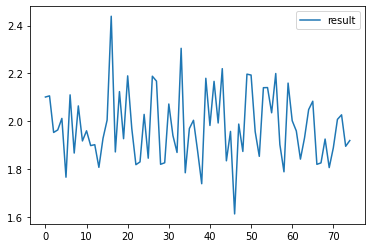

In [389]:
df_out.plot()

In [403]:
maxlag=11
test = 'ssr_chi2test'

def grangers_causation_matrix(data, test='ssr_chi2test'):    

    salida = pd.DataFrame(Portafolio.ids_filters, columns = ["var1","var2"])
    salida["p-value"] = np.nan

    for id,pair in enumerate(Portafolio.ids_filters):
        test_result = grangercausalitytests(data[list(pair)], maxlag=[maxlag], verbose=False) # remover parentesis en maxlag
        # p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]     
        p_values = round(test_result[maxlag][0][test][1],4)
        # min_p_value = np.min(p_values)
        # salida.iloc[id,2] = min_p_value
        salida.iloc[id,2] = p_values
    return salida

df_test = grangers_causation_matrix(b)

In [404]:
df_test["pass_test"] = df_test["p-value"]<0.05
final_df = df_test.copy()
final_df = final_df[final_df["pass_test"]==True]
final_df["pais_var1"] = final_df["var1"].apply(lambda x: x.split("_")[2])
final_df["pais_var2"] = final_df["var2"].apply(lambda x: x.split("_")[2])
final_df = final_df[final_df["pais_var1"]!=final_df["pais_var2"]]
final_df["lista1"] = final_df["var1"].apply(lambda x: x.join(final_df["var2"]))
final_df["lista2"] = final_df["var2"].apply(lambda x: x.join(final_df["var1"]))
final_df["final_val"] = final_df["lista1"]==final_df["lista2"]

In [405]:
stocks_porfolio_1 = final_df[["var1","var2","p-value"]]
stocks_porfolio_1

,var1,var2,p-value
30,returns_1_CHL_AGUAS_SERV. P,returns_32_COL_BANCOLOMBIA_FINAN,0.0009
31,returns_1_CHL_AGUAS_SERV. P,returns_33_COL_ECOPETROL_ENER,0.0010
32,returns_1_CHL_AGUAS_SERV. P,returns_34_COL_ENER. BOGOTA_SERV. P,0.0001
33,returns_1_CHL_AGUAS_SERV. P,returns_35_COL_SURAMERICANA_FINAN,0.0001
34,returns_1_CHL_AGUAS_SERV. P,returns_36_COL_INTERCON. ELECTRICA_INDUST,0.0000
...,...,...,...
5521,returns_75_PER_TREVALI MINING_MATER,returns_46_MEX_CEMEX_MATER,0.0004
5525,returns_75_PER_TREVALI MINING_MATER,returns_50_MEX_GRUPO CARSO_CONS. DISCRE,0.0430
5526,returns_75_PER_TREVALI MINING_MATER,returns_51_MEX_INBURSA_FINAN,0.0406
5527,returns_75_PER_TREVALI MINING_MATER,returns_52_MEX_BANORTE_FINAN,0.0427


In [392]:
stocks_porfolio = final_df[["var1","var2","p-value"]]
stocks_porfolio

,var1,var2,p-value
30,returns_1_CHL_AGUAS_SERV. P,returns_32_COL_BANCOLOMBIA_FINAN,0.0009
31,returns_1_CHL_AGUAS_SERV. P,returns_33_COL_ECOPETROL_ENER,0.0003
32,returns_1_CHL_AGUAS_SERV. P,returns_34_COL_ENER. BOGOTA_SERV. P,0.0000
33,returns_1_CHL_AGUAS_SERV. P,returns_35_COL_SURAMERICANA_FINAN,0.0000
34,returns_1_CHL_AGUAS_SERV. P,returns_36_COL_INTERCON. ELECTRICA_INDUST,0.0000
...,...,...,...
5526,returns_75_PER_TREVALI MINING_MATER,returns_51_MEX_INBURSA_FINAN,0.0144
5527,returns_75_PER_TREVALI MINING_MATER,returns_52_MEX_BANORTE_FINAN,0.0030
5528,returns_75_PER_TREVALI MINING_MATER,returns_53_MEX_GRUPO MEXICO_MATER,0.0016
5530,returns_75_PER_TREVALI MINING_MATER,returns_55_MEX_WALMEX_CONS. BAS,0.0052


In [359]:
stocks_porfolio = final_df[["var1","var2","p-value"]]
stocks_porfolio

,var1,var2,p-value
34,diff_1_CHL_AGUAS_SERV. P,diff_36_COL_INTERCON. ELECTRICA_INDUST,0.0060
38,diff_1_CHL_AGUAS_SERV. P,diff_40_COL_CORFICOL_FINAN,0.0355
41,diff_1_CHL_AGUAS_SERV. P,diff_43_MEX_MOVIL_TELECOM,0.0433
43,diff_1_CHL_AGUAS_SERV. P,diff_45_MEX_BANCO STDER_FINAN,0.0280
44,diff_1_CHL_AGUAS_SERV. P,diff_46_MEX_CEMEX_MATER,0.0001
...,...,...,...
5481,diff_75_PER_TREVALI MINING_MATER,diff_6_CHL_CAP_MATER,0.0302
5500,diff_75_PER_TREVALI MINING_MATER,diff_25_CHL_NORTE GRANDE_FINAN,0.0127
5504,diff_75_PER_TREVALI MINING_MATER,diff_29_CHL_SECURITY_FINAN,0.0145
5521,diff_75_PER_TREVALI MINING_MATER,diff_46_MEX_CEMEX_MATER,0.0147


<AxesSubplot:>

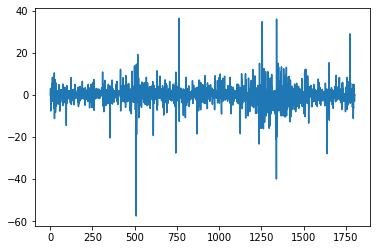

In [365]:
# Portafolio.df["1_CHL_AGUAS_SERV. P"].plot()
b["diff_1_CHL_AGUAS_SERV. P"].plot()

<AxesSubplot:>

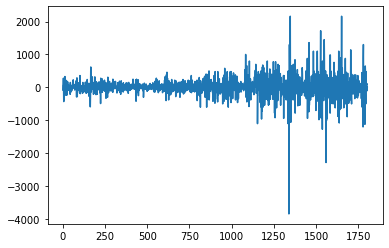

In [366]:
# Portafolio.df["36_COL_INTERCON. ELECTRICA_INDUST"].plot()
b["diff_36_COL_INTERCON. ELECTRICA_INDUST"].plot()